### Abstract

In this blog post we'll be looking at census data and trying to predict whether a person will have an income over $50,000. We will not use a persons' sex to predict their income. After training and implementing this algorithm, we will audit our model for gender bias. We will see that although the model doesn't appear to perform too differently across male and female groups, there are some differences in the model performance, which we will explore further and discuss.  

In [25]:
#| include: false

# Imports
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
from folktables import ACSDataSource, BasicProblem
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix



### Pulling and Prepping the Data

In [26]:
# Read in the data

STATE = "CA"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)
acs_data=acs_data[['PINCP', 'AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']]

acs_data.head()

,PINCP,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,48500.0,30,14.0,1,16,2,NaN,1,3.0,4.0,1,1,2,2,2.0,1,8,6.0
1,0.0,18,14.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0
2,13100.0,69,17.0,1,17,1,NaN,1,1.0,2.0,2,1,2,2,2.0,1,9,6.0
3,0.0,25,1.0,5,17,1,NaN,1,1.0,4.0,1,1,1,2,1.0,1,1,6.0
4,0.0,31,18.0,5,16,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0


In [27]:
features_to_use = ['AGEP', 'SCHL', 'MAR', 'RELP']

First, we're reading in the census data. We're also going to select some features that we're going to use for our mode. We'll be predicting income, so I chose some features that I think will be relevant -- age, education level, marriage status, and relationship to "head of household". Now, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍we'll ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍construct ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍BasicProblem that expresses that we are going to use the features we specified above to predict if a person's income ("PINCP") is over $50,000.  

In [28]:
IncomeProblem = BasicProblem(
    features=features_to_use,
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
features, label, group = IncomeProblem.df_to_numpy(acs_data)

### Basic Descriptives

Before we get into creating our model, let's get to know our dataset so that we understand the demographics that we're working with. We'll split our dataset into train and test sets. 

In [29]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [30]:
#| echo: false
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

This is what our dataset looks like. It has all of the features that we're going to use to train our model, and it has a "group" column where 1 represents a male and 2 represents a female. The "label" column, which we will isolate as our target variable, is a boolean (true for a person with income > $50,000, false otherwise). 

In [31]:
#| echo: false
df.head()

,AGEP,SCHL,MAR,RELP,group,label
0,77.0,16.0,2.0,0.0,2,True
1,29.0,20.0,5.0,2.0,1,False
2,60.0,21.0,1.0,0.0,2,False
3,27.0,19.0,5.0,13.0,2,False
4,63.0,23.0,3.0,0.0,1,True


Now, let's get some information about the data: 

In [32]:
#| echo: false
print("Number of individuals in the training set:", len(df))

Number of individuals in the training set: 303053


In [36]:
#| echo: false
print("Number of individuals in the training set with income over $50,000:",df["label"].sum())

Number of individuals in the training set with income over $50,000: 73963


In [35]:
#| echo: false

print("Number of males in the training set:", len(df[df["group"] == 1]))
print("Number of females in the training set:", len(df[df["group"] == 2]))

Number of males in the training set: 149294
Number of females in the training set: 153759


In [37]:
#| echo: false

print("Male proportion w/ income over $50,000:", 
      round(len(df[(df["group"] == 1) & (df["label"] == True)]) / len(df[df["group"] == 1]), 2))
print("Female proportion w/ income over $50,000:", 
      round(len(df[(df["group"] == 2) & (df["label"] == True)]) / len(df[df["group"] == 2]), 2))


Male proportion w/ income over $50,000: 0.3
Female proportion w/ income over $50,000: 0.19


We can see that there are more females than males in the training set, although not by much. It's almost evenly split. There are also about 10% more males than females have an income of over $50,000. It's important to understand the breakdown in our dataset because if we're looking for a model to perform well for both groups, we want there to be enough data in the training set for each group. We also want to be sure that we have people from each group with income above and below the threshold, so that the model can learn patterns about people in each group with each label. Now, let's look at intersectional trends in the data by breaking out the income groups by sex and education level. 

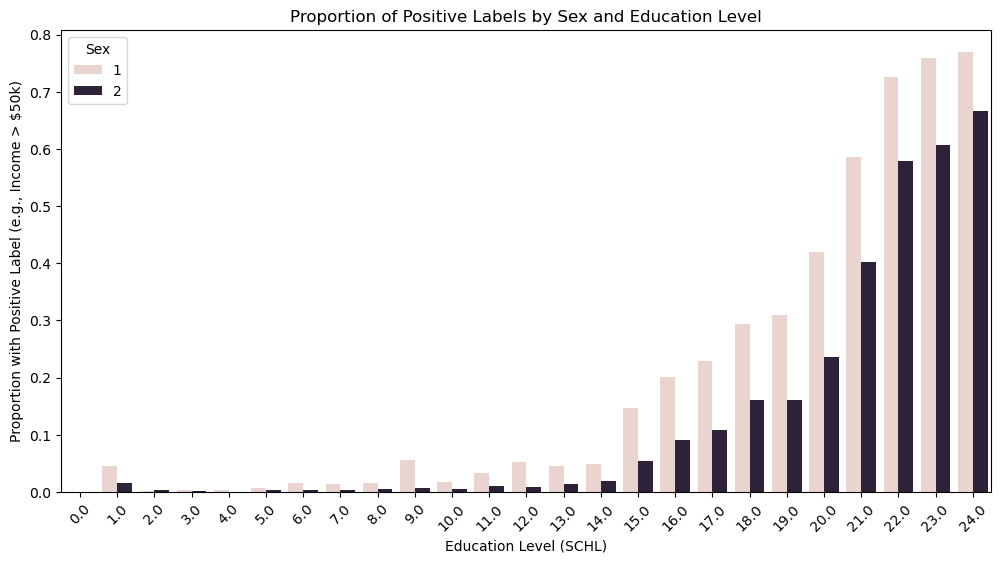

In [12]:
#| code-fold: true 
#| code-summary: "Plotting code"
# Compute proportions of positive labels by both SEX and SCHL
intersectional_counts = df.groupby(["group", "SCHL"])["label"].mean().reset_index()

# Rename columns for clarity
intersectional_counts.columns = ["Sex", "Education Level", "Proportion with Positive Label"]

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=intersectional_counts, 
    x="Education Level", 
    y="Proportion with Positive Label", 
    hue="Sex"
)

# Labels and title
plt.xlabel("Education Level (SCHL)")
plt.ylabel("Proportion with Positive Label (e.g., Income > $50k)")
plt.title("Proportion of Positive Labels by Sex and Education Level")
plt.legend(title="Sex")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()


Here, we can see that across all education levels, men are more likely to have an income over $50,000 than women are. We can also see that this gap seems to be exacerbated at lower education levels. There is a bigger gap between the proportion of men and proportion of women with income over $50,000 at 15-19 years of education than at the higher education levels of 21-24 years. This is an important example of intersectional trends, because we can see that the income disparity between men and women varies depending on education level. 

### Training the Model

Now that we understand our dataset, we'll train a support vector machine model to predict if an individual's income is over $50,000. An SVM model aims to find an optimal hyperplane in an N-dimensional space to separate data points into different classes. It is similar to a linear classification model, but it can be in multiple dimensions. The SVM algorithm maximizes the margin between the closest points of different classes. One of the parameters in an SVM model is the regularization term "C", which is used to balance the misclassification penalties with maximization. If the value of "C" is higher, the model more strictly penalizes misclassifications. Before training our model, we will use cross-validation to find an optimal value of this "C" parameter. 

In [14]:
#| code-fold: true 
#| code-summary: "Cross-val code"

model = make_pipeline(StandardScaler(), LinearSVC(dual=False))
model.fit(X_train, y_train)

# Define the pipeline
pipeline = make_pipeline(StandardScaler(), LinearSVC(dual=False, max_iter=5000))

# Define the hyperparameter grid for C
param_grid = {'linearsvc__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best C value
best_C = grid_search.best_params_['linearsvc__C']
print(f"Best C: {best_C}")

# Best model with optimal C
best_model = grid_search.best_estimator_

Best C: 0.001


Based on our cross-validation, the value of "C" that we should use is 0.001. Now, we'll create and train our model using a pipeline. The pipeline is used to sequentially apply transformations -- here, we are using StandardScaler() to standardize all of the features in the dataset. 

In [15]:
model = make_pipeline(StandardScaler(), LinearSVC(C=0.001, dual=False))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=0.001, dual=False))])

Now, that we've fit our model, we're going to test it on the test set and then audit the model for gender bias. Recall that we didn't include sex as one of the features in our model, so we're interested to see if the model we trained on other features might be implicitly biased by sex. 

### Auditing the Model

In [16]:
y_hat = model.predict(X_test)

In [38]:
#| echo: false
print("Overall accuracy:", round((y_hat == y_test).mean(),2))

Overall accuracy: 0.8


In [39]:
#| echo: false
print("Accuracy for men:", round((y_hat == y_test)[group_test == 1].mean(),2))

Accuracy for men: 0.79


In [41]:
#| echo: false
print("Accuracy for women:", round((y_hat == y_test)[group_test == 2].mean(),2))

Accuracy for women: 0.81


At first glance, we can see that our model is slightly more accurate for women, but it performs fairly similarly across each group when looking at accurate. But, let's get more precise to understand more about the differences in accuracy between groups. We'll get the accuracy using the accuracy score function, the PPV using the precision score function, and the true positive, true negative, false negative, and false positive rates from the confusion matrix. We'll get all of these metrics for the whole test set, as well as the test set filtered for the female and male groups. We will put all of these metrics into a dictionary for easy access when we plot these results next. 

In [21]:
#| code-fold: true
#| code-summary: "Code to calculate accuracy and error rates"

# Make predictions
y_pred = best_model.predict(X_test)

### Overall Measures ###
# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Compute overall PPV (Positive Predictive Value / Precision)
overall_ppv = precision_score(y_test, y_pred)

# Compute overall confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Compute overall False Positive Rate (FPR) and False Negative Rate (FNR)
overall_fpr = fp / (fp + tn)
overall_fnr = fn / (fn + tp)

# Print overall metrics
print("\n--- Overall Model Performance ---")
print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Overall PPV: {overall_ppv:.2f}")
print(f"Overall False Positive Rate (FPR): {overall_fpr:.2f}")
print(f"Overall False Negative Rate (FNR): {overall_fnr:.2f}")

### By-Group Measures ###
print("\n--- Subgroup Model Performance ---")
subgroup_results = []

for sex in [1, 2]:  # 1 = Male, 2 = Female
    mask = (group_test == sex)
    
    # Compute subgroup accuracy
    subgroup_accuracy = accuracy_score(y_test[mask], y_pred[mask])
    
    # Compute subgroup PPV
    subgroup_ppv = precision_score(y_test[mask], y_pred[mask])
    
    # Compute subgroup confusion matrix
    tn_s, fp_s, fn_s, tp_s = confusion_matrix(y_test[mask], y_pred[mask]).ravel()

    # Compute subgroup FPR and FNR
    subgroup_fpr = fp_s / (fp_s + tn_s)
    subgroup_fnr = fn_s / (fn_s + tp_s)
    
    group_name = "Male" if sex == 1 else "Female"
    print(f"\nGroup: {group_name}")
    print(f"  Accuracy: {subgroup_accuracy:.2f}")
    print(f"  PPV: {subgroup_ppv:.2f}")
    print(f"  False Positive Rate (FPR): {subgroup_fpr:.2f}")
    print(f"  False Negative Rate (FNR): {subgroup_fnr:.2f}")

    subgroup_results.append({
        "Sex": group_name,
        "Accuracy": subgroup_accuracy,
        "PPV": subgroup_ppv,
        "FPR": subgroup_fpr,
        "FNR": subgroup_fnr
    })

### Bias Measures ###
# Calibration: The model is considered calibrated if P(Y=1 | S=1) ≈ P(Y=1 | S=2)
calibration_diff = abs(y_pred[group_test == 1].mean() - y_pred[group_test == 2].mean())

# Error Rate Balance: FNR and FPR should be similar across groups
error_rate_balance = abs(subgroup_results[0]["FNR"] - subgroup_results[1]["FNR"]) + \
                     abs(subgroup_results[0]["FPR"] - subgroup_results[1]["FPR"])

# Statistical Parity: P(Y=1 | S=1) ≈ P(Y=1 | S=2)
statistical_parity_diff = abs(np.mean(y_pred[group_test == 1]) - np.mean(y_pred[group_test == 2]))

# Print Bias Metrics
print("\n--- Bias Metrics ---")
print(f"Calibration Difference: {calibration_diff:.2f}")
print(f"Error Rate Balance: {error_rate_balance:.2f}")
print(f"Statistical Parity Difference: {statistical_parity_diff:.2f}")



--- Overall Model Performance ---
Overall Accuracy: 0.80
Overall PPV: 0.63
Overall False Positive Rate (FPR): 0.08
Overall False Negative Rate (FNR): 0.56

--- Subgroup Model Performance ---

Group: Male
  Accuracy: 0.79
  PPV: 0.75
  False Positive Rate (FPR): 0.06
  False Negative Rate (FNR): 0.56

Group: Female
  Accuracy: 0.81
  PPV: 0.50
  False Positive Rate (FPR): 0.10
  False Negative Rate (FNR): 0.57

--- Bias Metrics ---
Calibration Difference: 0.01
Error Rate Balance: 0.05
Statistical Parity Difference: 0.01


These results tell us more information about the difference in model performance between the two groups. We can see that the male group has a lower false positive rate (FPR) than the female group, that is, our model is less likely to incorrectly predict that a man has income over $50,000 when he actually does not. The false negative rate (FNR) is very similar across groups, so we are pretty much equally likely to predict that a male or female does not have income over $50,000 when they actually do. The male group has a higher PPV value than the female group, which we'll explore further in the plot below. We will reproduce a plot from the COMPAS paper that compares the FPR and FNR rates across groups and plots potential combinations of FPR/FNR rates for each group. The plot also looks at the potential combinations of FPR/FNR rates for the female group if we fix the PPV rate for the female group to the larger PPV value of the male group. 

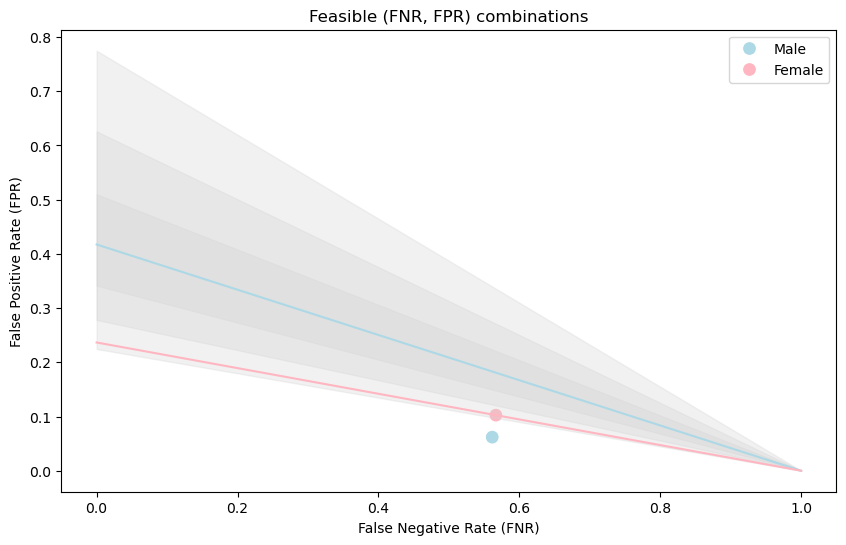

In [23]:
#| code-fold: true
#| code-summary: "Code to reproduce plot from COMPAS paper"

# Extract values for male and female
p_male = np.mean(y_test[group_test == 1])  # Prevalence of male
p_female = np.mean(y_test[group_test == 2])  # Prevalence of female

PPV_female = subgroup_results[1]["PPV"] # Observed PPV for females
PPV_male_fixed = PPV_female # Set PPV_male to PPV_female

# Extract FNR and FPR values for observed points
fnr_values = [subgroup_results[0]["FNR"], subgroup_results[1]["FNR"]]
fpr_values = [subgroup_results[0]["FPR"], subgroup_results[1]["FPR"]]
labels = [subgroup_results[0]["Sex"], subgroup_results[1]["Sex"]]

# Generate range of FNR values from 0 to 1
fnr_range = np.linspace(0, 1, 100)

# Compute feasible FPR values for males
fpr_feasible_male = ((1 - fnr_range) * p_male * (1 - PPV_male_fixed)) / (PPV_male_fixed * (1 - p_male))

# Compute feasible FPR values for females when PPV_female = PPV_male
fpr_feasible_female = ((1 - fnr_range) * p_female * (1 - PPV_female)) / (PPV_female * (1 - p_female))

# Define range of delta values for shading
delta_values = [0.05, 0.1, 0.15]  # Smaller delta -> smaller feasible region

plt.figure(figsize=(10, 6))

# Scatter plot of observed values
sns.scatterplot(x=fnr_values, y=fpr_values, hue=labels, palette=["lightblue", "lightpink"], s=100)

# Plot feasible set for males
plt.plot(fnr_range, fpr_feasible_male, color="lightblue", label="Feasible Set (Male)")

# Plot feasible set for females when PPV_female = PPV_male
plt.plot(fnr_range, fpr_feasible_female, color="lightpink", label="Feasible Set (Female, PPV=PPV_male)")

# Add nested shaded regions for varying PPV_female constraints
for i, delta in enumerate(delta_values):
    # PPV_female_upper = PPV_male + delta
    # PPV_female_lower = PPV_male - delta
    
    PPV_male_upper = PPV_female + delta
    PPV_male_lower = PPV_female - delta


    # Compute feasible FPR values for upper and lower PPV bounds
    fpr_feasible_upper = ((1 - fnr_range) * p_male * (1 - PPV_male_upper)) / (PPV_male_upper * (1 - p_male))
    fpr_feasible_lower = ((1 - fnr_range) * p_male * (1 - PPV_male_lower)) / (PPV_male_lower * (1 - p_male))

    # Fill region between upper and lower bounds
    plt.fill_between(fnr_range, fpr_feasible_lower, fpr_feasible_upper, color="lightgrey", alpha=0.3)

# Labels and title
plt.xlabel("False Negative Rate (FNR)")
plt.ylabel("False Positive Rate (FPR)")
plt.title("Feasible (FNR, FPR) combinations")

# Show plot
plt.show()

This chart is a reproduction of the Chouldechova paper that we discussed in class. We fixed ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the proportion of true positive labels  for eac‍‍‍‍‍‍‍‍‍‍‍‍‍h group, and we set the PPV values to be equal across both groups. The pink and blue points show the observed FPR and FNR rates for the male and female groups. The lines represent the possible combinations of FPR and FNR for each group, with the PPV for the male group fixed at the lower PPV that we observed for the female group. Given this, we can see that if we wanted the male FPR to be the same as the female FPR, we would need to increase the false negative rate around 35% so that the blue point would shift right onto the blue line. This tells us that we would need to make the model for males much less accurate than it is now to make the models "equal" in their FPR. 

### Concluding Discussion

Ultimately, this model didn't exhibit that much bias. Even though the male group had a higher PPV, the accuracy, FPRs, and FNRs were similar across the two groups. There are many people that might be interested in this model, like people doing credit risk assessment, recruiters and employers, or banks. These institutions would all have an interest in predicting how much income an individual might make. At a large scale, this model might be slightly more accurate for predicting male income. This could potentially have a negative impact on females because they might be more likely to be denied credit or a job if their income is predicted to be lower than it actually is. This could lead to biased employment practices, unfair denial of services, or housing discrimination. On the positive side, this model could have the impact of streamlining financial services and job-matching or aiding governments in economic research and policy planning with access to income data. I didn't feel that this model displays ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍problematic ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍bias. The error rates were very similar across groups, but I could see the potential for a model like this to be biased against women, given the systemic wage gap and sexism inherent in our society. Some of the other problems ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍associated with deploying this model, like privacy issues and regulatory compliance. To mitigate these potential impacts, it would be useful to conduct bias audits at a large scale, like the one we did here. It could also be important to ensure that humans, instead of the algorithm, end up having the final say about decisions that might be impacted by the model results. 